# Loading the ECCOv4 state estimate fields on the native model grid

## Objectives

Introduce several methods for loading the ECCOv4 state estimate files on the native model grid.

## Introduction 

ECCOv4 native-grid state estimate fields are packaged together as NetCDF files.  We have been improving how these files are created, what fields they contain, and how they are distributed in directories.  As of this writing, Sep 2019, the latest version of these files can be found here:

https://ecco.jpl.nasa.gov/drive/files/Version4/Release3_alt (po.daac drive, recommended)

https://web.corral.tacc.utexas.edu/OceanProjects/ECCO/ECCOv4/Release3_alt/  (mirror at U. Texas, Austin)

This tutorial document is current with the files in the above directories as of September 2019.


## NetCDF File Format

ECCOv4 state estimate fields are provided as NetCDF files with one variable and one year per file.  State estimate fields are provided as **monthly means**, **daily means** and **monthly snapshots**.  The file directories for NetCDF files should look something like (although exact naming may vary):

* /nctiles_monthly/**VARIABLE_NAME**/**VARIABLE_NAME_YYYY**.nc
* /nctiles_monthly_snapshots/**VARIABLE_NAME**/**VARIABLE_NAME_YYYY**.nc
* /nctiles_daily/**VARIABLE_NAME**/**VARIABLE_NAME_YYYY**.nc

While the model grid files are provided here:

* /nctiles_grid/ECCOv4r3_grid.nc

Typical file sizes are:
~~~
3D monthly-mean and monthly-snapshot fields:  265mb (50 levels x 12 months x 25 years x 13 tiles)
2D monthly-mean fields                     :    6mb ( 1 level  x 12 months x 25 years x 13 tiles)
2D daily-mean fields                       :  150mb ( 1 level  x 365 days  x 12 years x 13 tiles)
~~~

The advantages of aggregating one year of data into a single NetCDF file is that the I/O time per data element.  One nice feature of using the ``xarray`` and ``Dask`` libraries is that we do not have to load the entire file contents into RAM to work with them.  

## Two methods to load one ECCOv4 NetCDF file 

In ECCO NetCDF files, all 13 tiles for a given year are aggregated into a single file.  Therefore, we can use the ``open_dataset`` routine from ``xarray`` to open a single NetCDF variable file.

Alternatively, the subroutine ``load_ecco_var_from_years_nc`` allows you to optionally specify a subset of vertical levels or tiles to load using optional arguments.

We'll show both methods.  First ``open_dataset`` then ``load_ecco_var_from_years_nc``

### First set up the environment,  load model grid parameters.

In [1]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:
sys.path.append('/Users/ifenty/ECCOv4-py')

import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/ifenty/ECCOv4-release/'

## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/Release3_alt/'

## define the directory with the model grid
grid_dir = ECCO_dir + 'nctiles_grid/'

## load the grid
grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc')

### Loading a single ECCOv4 variable NetCDF file using ``open_dataset``

In [4]:
SSH_dir = ECCO_dir + '/nctiles_monthly/SSH/'
SSH_dataset = xr.open_dataset(SSH_dir + '/SSH_2010.nc')
SSH_dataset.SSH

<xarray.DataArray 'SSH' (time: 12, tile: 13, j: 90, i: 90)>
[1263600 values with dtype=float32]
Coordinates:
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    XC       (tile, j, i) float32 ...
    YC       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter     (time) int32 ...
  * time     (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Attributes:
    units:          m
    long_name:      Surface Height Anomaly adjusted with global steric height...
    standard_name:  sea_surface_height

``SSH_dataset.SSH`` contains 12 months of data across 13 tiles.

Let's plot the first time record of this file.

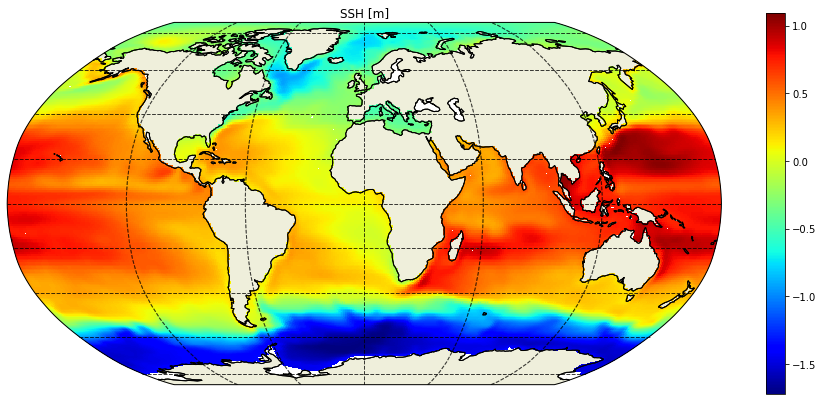

In [5]:
SSH  = SSH_dataset.SSH.isel(time=0)
# mask to nan where hFacC(k=0) = 0
SSH  = SSH.where(grid.hFacC.isel(k=0))

fig  = plt.figure(figsize=(16,7))
ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, SSH, show_colorbar=True);plt.title('SSH [m]');

### Loading a single ECCOv4 variable NetCDF file using ``load_ecco_var_from_years_nc``

We'll now load the same 2010 SSH file using ``load_ecco_var_from_years_nc``.  This time we specify the directory containing the NetCDF file, the variable that want to load and the year of interest. 

In [6]:
# single year:  2010
SSH_dataset_2010 = ecco.load_ecco_var_from_years_nc(SSH_dir, \
                           'SSH', years_to_load = [2010]).load()
SSH_dataset_2010.attrs = []
SSH_dataset_2010

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 13, time: 12)
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 ... 2011-01-01
    iter       (time) int32 158532 159204 159948 160668 ... 165084 165804 166548
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Dimensions without coordinates: nv
Data variables:
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Loading a subset of single ECCOv4 variable NetCDF file using ``load_ecco_var_from_years_nc``


One benefit of using  ``load_ecco_var_from_years_nc`` over ``open_dataset`` is that you can optionally specify a subset of vertical levels or tiles to load using optional arguments with the *tiles_to_load* and *k_subset* optional arguments.  

By default 

* *tiles_to_load* = [0, 1, ... 12]
* k_subset = []     

To load a subset of tiles, specify the desired tile indices in *tiles_to_load*.  For example, to load tiles 3,4 and 5:
~~~~
tiles_to_load = [3, 4, 5]
~~~~

To load a subset of depth levels, specify the desired depth level indices in *k_subset*.  For example, to load the top 5 levels:
~~~~
k_subset = [0,1,2,3,4]
~~~~

In the following example we load ``THETA`` for tiles 7,8,9 and depth levels 0:34.

In [7]:
theta_dir= ECCO_dir + '/nctiles_monthly/THETA/'
theta_subset = ecco.load_ecco_var_from_years_nc(theta_dir, \
                                                'THETA', years_to_load = [2010], \
                                                tiles_to_load = [ 7,8,9], \
                                                k_subset = [0,1,2,3,4]).load()
theta_subset.attrs = []
theta_subset

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, k: 5, nv: 2, tile: 3, time: 12)
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4
    Z          (k) float32 -5.0 -15.0 -25.0 -35.0 -45.0
    PHrefC     (k) float32 49.05 147.15 245.25 343.35 441.45
    drF        (k) float32 10.0 10.0 10.0 10.0 10.0
    XC         (tile, j, i) float32 142.16208 142.22801 ... -115.5476 -115.18083
    YC         (tile, j, i) float32 67.47211 67.33552 ... -80.43542 -80.43992
    rA         (tile, j, i) float32 212633870.0 351016450.0 ... 47093870.0
    hFacC      (tile, k, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * tile       (tile) int32 7 8 9
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 ... 2011-01-01
    iter       (time) int32 158532 159204 159948 160668 ... 165084 165804 166548
  * time       (time) datetime64[ns] 201

As expected, ``theta_subset`` has 3 tiles and 5 vertical levels.

## Loading multiple years of single ECCOv4 variable using ``load_ecco_var_from_years_nc``

Another benefit of ``load_ecco_var_from_years`` is that you can load more than one year of output.  First we'll show loading *two* years then *all* of the years of output available in the file directory

In [8]:
# two years:  2010 and 2011
SSH_2010_2011 = ecco.load_ecco_var_from_years_nc(SSH_dir, \
                                                'SSH', 
                                                 years_to_load = [2010, 2011]).load()
SSH_2010_2011.attrs = []
SSH_2010_2011

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 13, time: 24)
Coordinates:
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 ... 2012-01-01
    iter       (time) int32 158532 159204 159948 160668 ... 173844 174564 175308
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2011-12-16T12:00:00
Dimensions without coordinates: nv
Data variables:
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Notice that SSH_2010_2011 has 24 time records

In [9]:
# all years
SSH_all = ecco.load_ecco_var_from_years_nc(SSH_dir, \
                                           'SSH', 
                                           years_to_load = 'all').load()
SSH_all.attrs = []
SSH_all

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 13, time: 288)
Coordinates:
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-31
    iter       (time) int32 732 1428 2172 2892 ... 208164 208908 209628 210360
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2015-12-16T12:00:00
Dimensions without coordinates: nv
Data variables:
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Now that we have all 288 month records of SSH.

## Loading one or more years of more than variable using ``recursive_load_ecco_var_from_years_nc``

With ``recursive_load_ecco_var_from_years_nc`` one can specify one or more variables to load, one or more years to load, while also requesting only a subset of tiles and vertical levels.  

Let's demonstrate by first loading all of the information for monthly-averaged ``SSH`` and ``THETA`` fields for the years 2010, 2011, and 2012.  We'll then load SSH and OBP for *all* of the years and tile 6.  Finally, we'll load all of the monthly-mean variables for the year 2010.

### Loading SSH and THETA for 2010-2012

In [10]:
nctiles_monthly_dir = ECCO_dir + 'nctiles_monthly/'
SSH_THETA_2010_2012 = \
        ecco.recursive_load_ecco_var_from_years_nc(nctiles_monthly_dir, \
                                                   vars_to_load=['SSH','THETA'], \
                                                   years_to_load = [2010, 2011, 2012]).load()

searching /Users/ifenty/ECCOv4-release//Release3_alt/nctiles_monthly/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for SSH ... su

In [11]:
SSH_THETA_2010_2012

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, k: 50, nv: 2, tile: 13, time: 36)
Coordinates:
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    Z          (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    drF        (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    PHrefC     (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    hFacC      (tile, k, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 

We see three years (36 months) of data and 13 tiles and 50 vertical levels.

### Loading SSH and OBP for all years and tile 6
Now let's demonstrate how the ``recursive_load_ecco_var_from_years_nc`` routine enable us to load all of the years of output for multiple variables.  The trick is to specify the directory that contains all of the variables.  The routine will recursively search all subdirectories for these fields.  Note, this only works if the subdirectories are of the same temporal period (monthly mean, daily mean, or snapshots).  

In [12]:
SSH_OBP_2010_tile_6 = \
        ecco.recursive_load_ecco_var_from_years_nc(nctiles_monthly_dir, \
                                                   vars_to_load=['SSH', 'OBP'], \
                                                   years_to_load = 'all', \
                                                   tiles_to_load = 6).load()                                           

searching /Users/ifenty/ECCOv4-release//Release3_alt/nctiles_monthly/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for OBP ... su

In [13]:
SSH_OBP_2010_tile_6

<xarray.Dataset>
Dimensions:    (i: 90, j: 90, nv: 2, tile: 1, time: 288)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2015-12-16T12:00:00
    YC         (tile, j, i) float32 67.57341 67.67698 ... 67.67698 67.57341
    rA         (tile, j, i) float32 246414940.0 412417600.0 ... 246414940.0
    XC         (tile, j, i) float32 52.0 52.331654 ... -127.66834 -128.0
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 6
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-31
    iter       (time) float64 732.0 1.428e+03 2.172e+03 ... 2.096e+05 2.104e+05
Dimensions without coordinates: nv
Data variables:
    SSH        (time, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    OBP        (time, tile, j, i) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    geospatial_lat_max:       89.739395
  

## Loading the entire (or large fractions) of the entire ECCOv4 solution using Dask

We can load the entire ECCOv4 solution into our workspace and perform calcuations with the entire solution thanks to the amazing ``Dask`` library implemented in the ``xarray`` package.  Why is this useful?  Because it is unlikely that the machine you are working on has enough RAM to load the entire ECCOv4 solution at one time.  By using ``Dask`` we can *virtually* load all of the ECCO fields into memory.  ``Dask`` even enables us to do calculations with these fields even though the entire data is never stored in memory.  

Here is some more information about these features from the ``Dask`` website, 
https://docs.dask.org/

1. **Larger-than-memory:** Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.*

2. **Blocked Algorithms:** Perform large computations by performing many smaller computations

Finally, in cluster environments ``Dask`` can distribute computations across many cores to speed up large redundant calculation.  

An in-depth description of ``Dask`` is outside the scope of this tutorial.  For the moment, let us compare the operation of loading **all** the 2D daily-mean fields for 2010 both using ``Dask`` and without using ``Dask``.  Without ``Dask`` these fields will be loaded into memory.  With ``Dask`` we will only load a minimum of the ``Datasets``, the Dimensions and Coordinates.

To demonstate some of the advantages of using ``DASK`` to load and analyze ECCO fields, let's load every monthly-mean variable for two years with and without ``Dask``.  Then we'll load all of the monthly-mean fields for four years using Dask.  At the end we'll compare their *times to load* and *memory footprints*.

### Example 1a: Load *all* monthly-mean ECCO fields into memory without ``Dask``

The ``.load()`` suffix appended to the end of these load commands is a command to fully load fields into memory.  Without it, ``Dask`` only *virtually* loads the fields.

In [14]:
mon_mean_dir = ECCO_dir + 'nctiles_monthly/'
import time
t_0 = time.time()

large_subset_no_dask = \
    ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                               vars_to_load='all', \
                                               years_to_load=[2010, 2011],\
                                               less_output=True).load()

delta_t_no_dask =  time.time() - t_0

searching /Users/ifenty/ECCOv4-release//Release3_alt/nctiles_monthly/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT .

In [15]:
large_subset_no_dask

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, nv: 2, tile: 13, time: 24)
Coordinates:
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 2010-01-01 2010-02-01 ... 2012-01-01
    iter       (time) int32 158532 159204 159948 160668 ... 173844 174564 175308
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2011-12-16T12:00:00
    dxG        (tile, j_g, i) float32 15584.907 15589.316 ... 23142.107
    rAs        (tile, j_g, i) float32 179944260.0 180486990.0 ... 364150620.0
    dyC        (tile, j_g, i) float32 11563.71


### Example 1b: Load *all* monthly-mean ECCO fields into memory using ``Dask``

This time we will omit the ``.load()`` suffix and use ``Dask``.

In [16]:
t_0 = time.time()
large_subset_with_dask = ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                           vars_to_load='all', \
                                           years_to_load=[2010, 2011])
delta_t_with_dask =  time.time() - t_0

searching /Users/ifenty/ECCOv4-release//Release3_alt/nctiles_monthly/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT .

In [17]:
large_subset_with_dask

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, nv: 2, tile: 13, time: 24)
Coordinates:
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    iter       (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2011-12-16T12:00:00
    dxG        (tile, j_g, i) float32 15584.907 15589.316 ... 23142.107
    rAs        (tile, j_g, i) float32 179944260.0 180486990.0 ... 364150620.0
    dyC        (tile, j_g, i) float32 11563.

### Example 2: Load 5 years of every monthly-mean field with ``DASK``

In [18]:
t_0 = time.time()
all_fields_with_dask = ecco.recursive_load_ecco_var_from_years_nc(mon_mean_dir, \
                                           vars_to_load='all', \
                                           years_to_load=[2008, 2009, 2010, 2011, 2012], \
                                           dask_chunk=True)
delta_t_all_with_dask =  time.time() - t_0

searching /Users/ifenty/ECCOv4-release//Release3_alt/nctiles_monthly/ for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVr_SLT .

### Results

Now we examine the time it took to load these fields and the comparative memory footprints

In [19]:
print ('loaded  large_subset_no_dask in   ', np.round(delta_t_no_dask), 'sec')
print ('loaded  large_subset_with_dask in ', np.round(delta_t_with_dask), 'sec')
print ('loaded  all_with_dask in          ', np.round(delta_t_all_with_dask), 'sec')

loaded  large_subset_no_dask in    151.0 sec
loaded  large_subset_with_dask in  12.0 sec
loaded  all_with_dask in           22.0 sec


The real advantage of using Dask comes when examining the size of these objects in memory.  The 'pympler' package allows you to see the memory footprint of these objects.

https://pythonhosted.org/Pympler/index.html

In [20]:
# Estimate the memory footprint in MB
from pympler import asizeof

s = 0
F = large_subset_no_dask
for i in F.variables.keys():
    s += asizeof.asizeof(large_subset_no_dask[i])
print('large_subset_no_dask   : ', np.round(s/2**20), 'mb')

F = large_subset_with_dask
s = 0
for i in F.variables.keys():
    s += asizeof.asizeof(F[i])
print('large_subset_with_dask : ', np.round(s/2**20), 'mb')

F = all_fields_with_dask
s = 0
for i in F.variables.keys():
    s += asizeof.asizeof(F[i])
print('all_fields_with_dask   : ', np.round(s/2**20), 'mb')

large_subset_no_dask   :  15507.0 mb
large_subset_with_dask :  607.0 mb
all_fields_with_dask   :  610.0 mb


Using ``Dask``, we were able to load every monthly mean field for an five years in 23 seconds compared to fully loading just two years of data into memory which took 91 seconds.  

In terms of memory, the 5 years of data in *all_fields_with_dask* object takes a small fraction (611 mb vs 15507 mb) of the memory of the 2 years of data in *large_subset_no_dask*.  With much less memory reserved to hold all of the fields, we have more memory avaiable for calculations on the parts of the fields that we care about.

Go ahead and experiment with using ``Dask`` to load the daily-averaged fields.  Because all of the daily-averaged fields in the standard ECCO product are 2D, loading them with ``Dask`` takes very little time!

## Summary

Now you know how effecient ways to load ECCOv4 NetCDF files, both when you are reading variables split into *tiles*  and when you are reading variables aggregated by year.

Using ``Dask`` we showed that one can prepare a work environment where ECCO model variables are accessible for calculations even without fully loading the fields into memory.